<a href="https://colab.research.google.com/github/MedAmine-SUDO/Tunisian-License-Plate-Recognition/blob/master/PlateSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License Plate Recognition using Image Processing

### First try

*Import libraries*

In [0]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)

import skimage.viewer
import skimage.measure

from skimage.measure import regionprops

import matplotlib.patches as patches
from skimage.transform import resize

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Viewer requires Qt
  if __name__ == '__main__':


In [0]:
cd LicensePlateProject/

/content/drive/My Drive/LicensePlateProject


In [0]:
#Path definitions
PLATES = './plateImages/'

*Read image in grayscale*

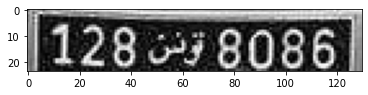

In [0]:
gray = cv2.imread(PLATES+"1.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(gray, cmap=plt.cm.gray)

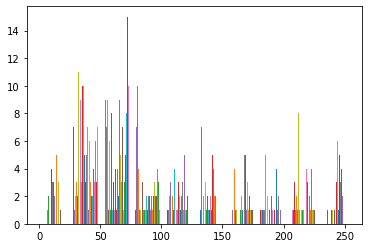

In [0]:
plt.hist(gray);

*Apply Niblack's local threshhold*

<class 'numpy.ndarray'>


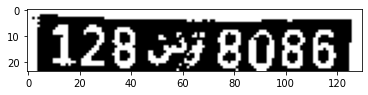

In [0]:
#Local binarization Niblack's
window_size = 25
thresh_niblack = threshold_niblack(gray, window_size=window_size, k=0)
binary_niblack = gray > thresh_niblack
plt.imshow(binary_niblack, cmap=plt.cm.gray)
print(type(binary_niblack))

In [0]:
#Seconf method
gray = gray * 255
threshold_value = threshold_otsu(gray)
binary_car_image = gray > threshold_value

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


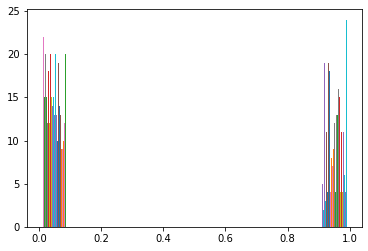

In [0]:
plt.hist(binary_niblack);

In [0]:
license_plate = np.invert(binary_car_image)
label_image = skimage.measure.label(license_plate)
print(label_image.shape[0])

24


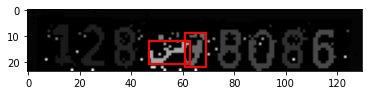

In [0]:
fig, ax1 = plt.subplots(1)
ax1.imshow(label_image, cmap="gray")
character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(label_image):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)
# print(characters)
plt.show()

First method with global threshhold

In [0]:
ctrs,_ = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
digits = []
for rect in rects:
    x = rect[0]
    y = rect[1]
    w = rect[2]
    h = rect[3]
    crop_im = im[y:y+h, x:x+w]
    #if w > h:
    #    continue
    #if h < 15:
    #    continue
    digits.append(crop_im)
    plt.figure(figsize=(3,3))
    plt.imshow(crop_im)
    plt.show()

### Another Try 

In [0]:
# import the necessary packages
from collections import namedtuple
from skimage.filters import threshold_local
from skimage import segmentation
from skimage import measure
from imutils import perspective
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

In [0]:
#Path definitions
PLATES = './plateImages/'

In [0]:
plate = cv2.imread(PLATES+"1.jpg")

In [0]:
print(plate.shape)

(24, 130, 3)


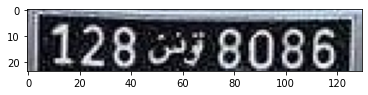

In [0]:
plt.imshow(plate)

In [0]:
# extract the Value component from the HSV color space and apply adaptive thresholding
# to reveal the characters on the license plate
V = cv2.split(cv2.cvtColor(plate, cv2.COLOR_BGR2HSV))[2]
T = threshold_local(V, 29, offset=15, method="gaussian")
thresh = (V > T).astype("uint8") * 255
thresh = cv2.bitwise_not(thresh)

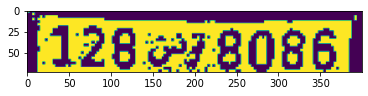

In [0]:
# resize the license plate region to a canonical size
plate = imutils.resize(plate, width=400)
thresh = imutils.resize(thresh, width=400)
plt.imshow(thresh)

In [0]:
# perform a connected components analysis and initialize the mask to store the locations
# of the character candidates
labels = measure.label(thresh, neighbors=8, background=0)
charCandidates = np.zeros(thresh.shape, dtype="uint8")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue

    # otherwise, construct the label mask to display only connected components for the
    # current label, then find contours in the label mask
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0]

In [0]:
if len(cnts) > 0:
    # grab the largest contour which corresponds to the component in the mask, then
    # grab the bounding box for the contour
    c = max(cnts, key=cv2.contourArea)
    (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)

    # compute the aspect ratio, solidity, and height ratio for the component
    aspectRatio = boxW / float(boxH)
    solidity = cv2.contourArea(c) / float(boxW * boxH)
    heightRatio = boxH / float(plate.shape[0])

    # determine if the aspect ratio, solidity, and height of the contour pass
    # the rules tests
    keepAspectRatio = aspectRatio < 1.0
    keepSolidity = solidity > 0.15
    keepHeight = heightRatio > 0.4 and heightRatio < 0.95

    # check to see if the component passes all the tests
    if keepAspectRatio and keepSolidity and keepHeight:
        # compute the convex hull of the contour and draw it on the character
        # candidates mask
        hull = cv2.convexHull(c)
        cv2.drawContours(charCandidates, [hull], -1, 255, -1)

### 30/05/2020 Yet Another Attempt



In [3]:
cd LicensePlateProject/

/content/drive/My Drive/LicensePlateProject


In [0]:
PLATES = './plateImages/'

In [190]:
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.filters import threshold_niblack
from skimage.filters import gaussian
from matplotlib import pyplot as plt
import imutils

import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from skimage.exposure import adjust_sigmoid


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Viewer requires Qt


In [0]:
#Read image using skimage
plate = imread(PLATES+'1.jpg', as_gray=True)

In [0]:
#Contrast enhancer
new_image = adjust_sigmoid(plate)

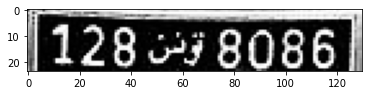

In [244]:
plt.imshow(new_image, cmap=plt.cm.gray)

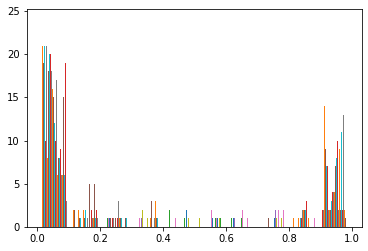

In [235]:
plt.hist(new_image);

In [0]:
gray_plate = new_image * 255

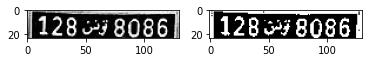

In [246]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_plate, cmap="gray")
threshold_value = threshold_niblack(gray_plate)
binary_plate = gray_plate > threshold_value
ax2.imshow(binary_plate, cmap='gray')
plt.show()

In [0]:
license_plate = np.invert(binary_plate)

In [0]:
labelled_plate = measure.label(binary_plate)

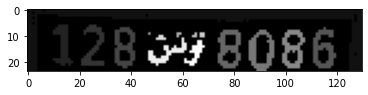

In [254]:
plt.imshow(labelled_plate, cmap='gray')

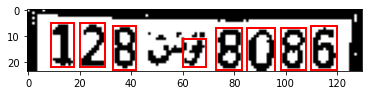

In [255]:
fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")
#character_dimensions = (0.20*license_plate.shape[0], 0.90*license_plate.shape[0], 0.10*license_plate.shape[1], 0.20*license_plate.shape[1])
character_dimensions = (10, 25, 5, 15)
min_height, max_height, min_width, max_width = character_dimensions
characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0
    #if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
    if region_height > region_width :
        roi = license_plate[y0:y1, x0:x1]
        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0-1, y0-1), (x1 - x0)+1, (y1 - y0)+1, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        #resized_char = resize(roi, (20, 20))
        characters.append(roi)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)
# print(characters)
plt.show()

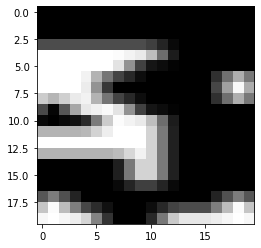

In [57]:
plt.imshow(characters[3], cmap='gray')

## License Plate recognition using BRNN + LSTM

In [0]:
PLATES = './plateImages/'